# Прогнозирование поведения акций

## 1. Подключение зависимостей 

In [1]:
import math 
import pandas_datareader as web 
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
from yahooquery import Ticker

ticket = 'CNK'

## 2. Получение обучающей выборки 

In [21]:
ticker = Ticker(ticket, asynchronous=True)
df = ticker.history(period='5d', interval='1m')
# df.info()

df = df.droplevel(0)
df

,low,high,close,open,volume
date,,,,,
2020-12-18 09:30:00,16.530001,16.780001,16.570000,16.780001,432940.0
2020-12-18 09:31:00,16.559999,16.650000,16.610001,16.570000,8202.0
2020-12-18 09:32:00,16.299999,16.600000,16.330000,16.580000,45978.0
2020-12-18 09:33:00,16.330000,16.530001,16.469999,16.330000,9996.0
2020-12-18 09:34:00,16.430000,16.469999,16.469999,16.430000,8989.0
...,...,...,...,...,...
2020-12-24 12:56:00,16.490000,16.514999,16.510000,16.514999,8716.0
2020-12-24 12:57:00,16.500099,16.520000,16.504999,16.500099,8797.0
2020-12-24 12:58:00,16.500000,16.530001,16.530001,16.500000,12724.0


## 3. Построение графика зависимости цены акции от времени 

In [3]:
plt.figure(figsize=(16, 8), dpi=800)
plt.title('Close price history')
# plt.plot(df['Close'])
plt.plot(df['close'])
plt.xlabel('Date', fontsize=16)
plt.ylabel('Close Price USD', fontsize=16)
plt.tight_layout()
plt.grid()
plt.show()

## 4. Формирование выборки

In [4]:
data = df.filter(['close'])
dataset = data.values
training_data_len = math.ceil(len(dataset) * .9)

training_data_len

1592

In [5]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.83660128],
       [0.86274567],
       [0.67973866],
       ...,
       [0.81045813],
       [0.80392203],
       [0.79738593]])

## 5. Формирование тестовой выборки

In [6]:
train_data = scaled_data[0:training_data_len:]
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

In [7]:
x_train, y_train = np.array(x_train), np.array(y_train)

In [8]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1],  1))
x_train.shape

(1532, 60, 1)

## 6. Обучение модели 

In [9]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [10]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [11]:
model.fit(x_train, y_train, batch_size=1, epochs=1)

1532/1532 [==============================] - 25s 17ms/step - loss: 0.0040


## 7. Формирование тестовой выборки и тестирование модели

In [12]:
test_data = scaled_data[training_data_len - 60: , :]
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

In [13]:
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [14]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
print(predictions)

[[16.590128]
 [16.580362]
 [16.58398 ]
 [16.594164]
 [16.602474]
 [16.593899]
 [16.573729]
 [16.557005]
 [16.550385]
 [16.552366]
 [16.554546]
 [16.546515]
 [16.52672 ]
 [16.516775]
 [16.506092]
 [16.512716]
 [16.516651]
 [16.51286 ]
 [16.50388 ]
 [16.48788 ]
 [16.469051]
 [16.450819]
 [16.435116]
 [16.420557]
 [16.408226]
 [16.395811]
 [16.38781 ]
 [16.382574]
 [16.370975]
 [16.356144]
 [16.345882]
 [16.32887 ]
 [16.317648]
 [16.314053]
 [16.314505]
 [16.323751]
 [16.341726]
 [16.362906]
 [16.384886]
 [16.403198]
 [16.416952]
 [16.4299  ]
 [16.438354]
 [16.446314]
 [16.458422]
 [16.470499]
 [16.480566]
 [16.48772 ]
 [16.492308]
 [16.491835]
 [16.491552]
 [16.487907]
 [16.482298]
 [16.480455]
 [16.480133]
 [16.478874]
 [16.47263 ]
 [16.466843]
 [16.460426]
 [16.453346]
 [16.443388]
 [16.432446]
 [16.42475 ]
 [16.418592]
 [16.41248 ]
 [16.407526]
 [16.404634]
 [16.408743]
 [16.408743]
 [16.404108]
 [16.400301]
 [16.39722 ]
 [16.3949  ]
 [16.393312]
 [16.39382 ]
 [16.393242]
 [16.397446]

## 8. Расчет среднеквадратичной ошибки

In [20]:
rmse = np.sqrt(np.mean([(p - y)**2 for p, y in zip(predictions, y_test)]))
print(rmse)

0.046241985665855766


## 9. Построение графика предсказаний

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/indexing.py:1781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


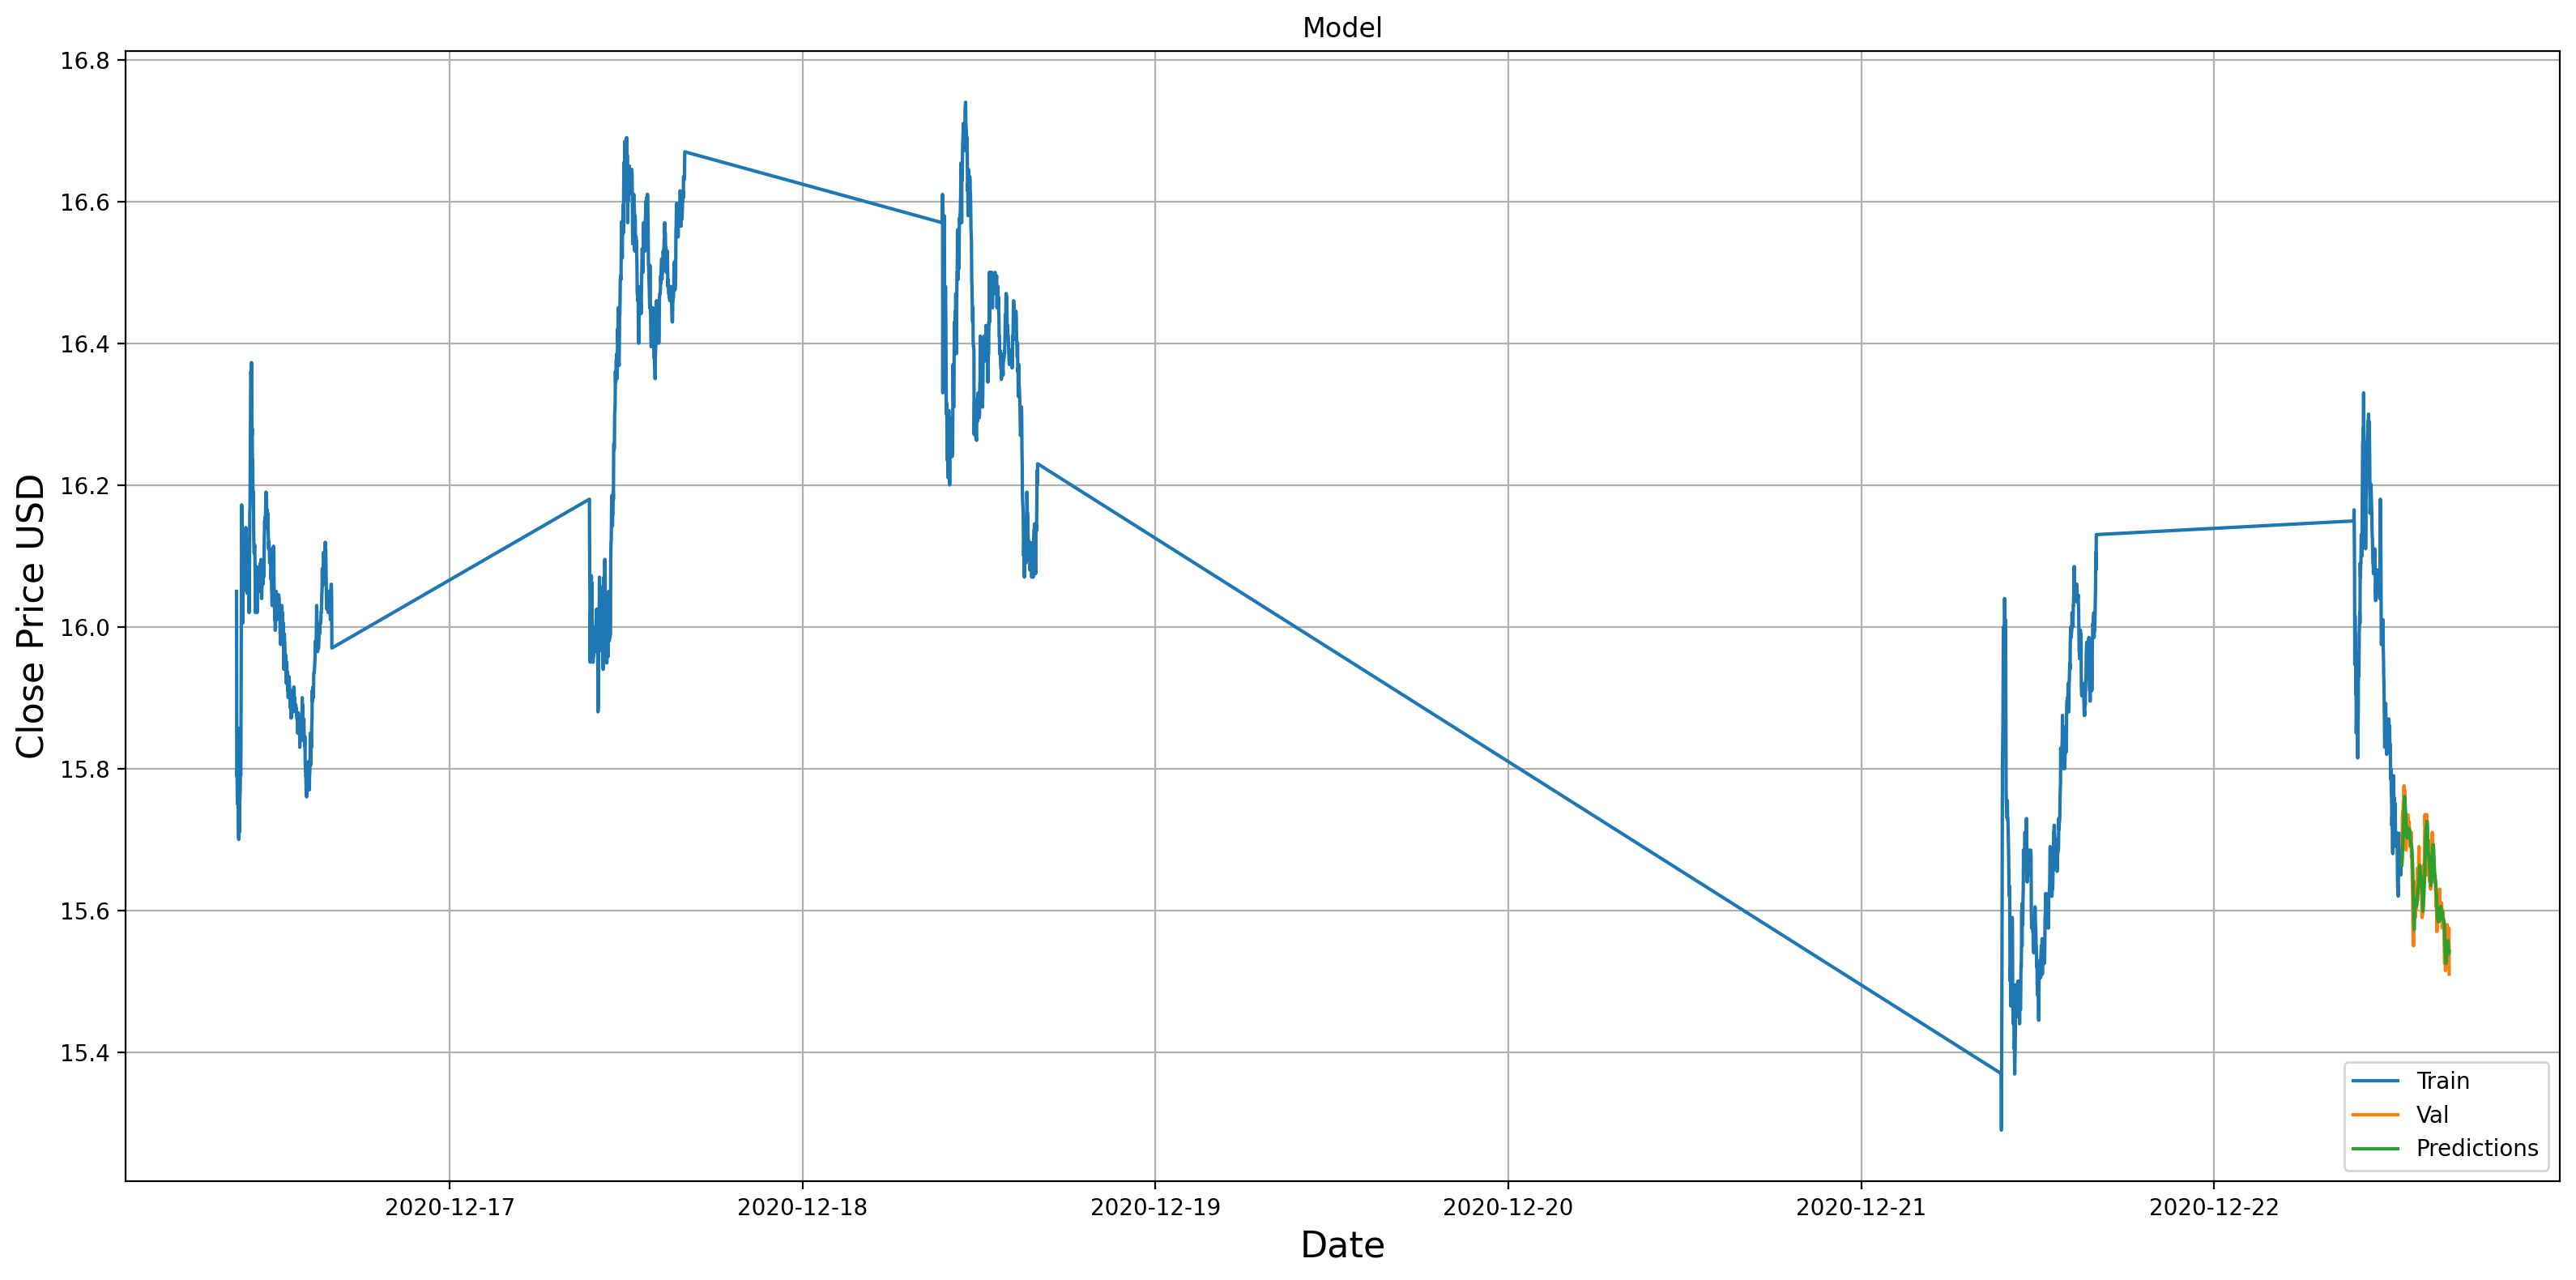

In [120]:
train = data[:training_data_len]
valid = data[training_data_len:]

valid.loc[:,'Predictions'] = predictions
plt.figure(figsize=(16, 8), dpi=200)
plt.title('Model')
plt.xlabel('Date', fontsize=16)
plt.ylabel('Close Price USD', fontsize=16)

plt.plot(train['close'])
plt.plot(valid[['close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.tight_layout()
plt.grid()
plt.show()

## 10. Предсказание стоимости закрытия следующей свечи

In [118]:
ticker = Ticker(ticket, asynchronous=True)
new_data = ticker.history(period='5d', interval='1m')

new_data = new_data.filter(['close'])

last_60 = new_data[-60:].values
last_60
last_60 = scaler.transform(last_60)

scaled = np.array([last_60])
scaled = np.reshape(scaled, (scaled.shape[0], scaled.shape[1], 1))
pred_price = scaler.inverse_transform(model.predict(scaled))

pred_price

array([[15.537887]], dtype=float32)